In [1]:
#importing modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

#import classifier modules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#plots
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp


# Definitions for fitting the separate models

In [2]:
#definitions that create and train the models

def train_DecisionTree(train_X, train_y):
    model= DecisionTreeClassifier(random_state=1234)
    
    #Hyper Parameters Set
    params = {'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
              'random_state':[123]}
    
    #Making models with hyper parameters sets
    model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
    
    #Learning
    model1.fit(train_X,train_y)
    
    return model1


def train_RandomForest(train_X, train_y):
    model=RandomForestClassifier()
    
    #hyper parameters set
    params = {'criterion':['gini','entropy'],
              'n_estimators':[10,15,20,25,30],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[3,4,5,6,7], 
              'random_state':[123],
              'n_jobs':[-1]}
    
    #Making models with hyper parameters sets
    model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
    
    #learning
    model1.fit(train_X,train_y)
    
    return model1


def train_SVM(train_X, train_y):
    model=svm.SVC()
    
    #Hyper Parameters Set
    params = {'C': [6,7,8,9,10,11,12], 
              'kernel': ['linear','rbf'],
              'probability': [True]}
    
    #Making models with hyper parameters sets
    model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
    
    #Learning
    model1.fit(train_X,train_y)
    
    return model1


def train_KNeighborsClassifier(train_X, train_y):
    model = KNeighborsClassifier(n_jobs=-1)
    
    #Hyper Parameters Set
    params = {'n_neighbors':[5,6,7,8,9,10],
              'leaf_size':[1,2,3,5],
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'n_jobs':[-1]}
    
    #Making models with hyper parameters sets
    model1 = GridSearchCV(model, param_grid=params, n_jobs=1)
    
    #Learning
    model1.fit(train_X,train_y)
    
    return model1

# Ensemble

In [3]:
t = time.time()

#loading datasets
data = pd.read_csv("Data/datasets_180_408_data.csv")


#data preprocessing

#deleting useless columns
#deleting the "id" column
data.drop("id",axis=1,inplace=True)
#deleting the "Unnamed: 32" column
data.drop("Unnamed: 32",axis=1,inplace=True) 

#counting the diagnosis variable
print(data.diagnosis.value_counts())

#replacing M and B with 1 and 0 respectively
data.diagnosis=data.diagnosis.map({'M':1,'B':0})

#shuffle rows of data to achieve a random split in the train and test set
data.sample(frac=1, random_state=0).reset_index(drop=True)


#initialize parameters for cross validation and train split
nfolds = 5
scores2 = []
fpr_train_dict = dict()
fpr_test_dict = dict()
tpr_train_dict = dict()
tpr_test_dict = dict()
roc_train_dict = dict()
roc_test_dict = dict()
train_y_dict = dict()
train_pred_dict = dict()
test_y_dict = dict()
test_pred_dict = dict()

#initialize to keep track of response variable and corresponding predictions over all the folds
for label in ['DT', 'RF', 'SVM', 'KN', 'soft']:
    train_y_dict[label+'All'] = []
    train_pred_dict[label+'All'] = []
    test_y_dict[label+'All'] = []
    test_pred_dict[label+'All'] = []

#Cross validation
for fold in range(nfolds):
    
    #split data into train and test data
    start_inx = int(len(data)*(fold/nfolds))
    end_inx = int(len(data)*((fold+1)/nfolds))
    train = data[(data.index < start_inx) | (data.index >= end_inx)]
    test = data[(data.index >= start_inx) | (data.index < end_inx)]

    #split the train and test data into independent and responsible variables
    train_X = train.iloc[:, 1:31]
    train_y = train.diagnosis
    test_X = test.iloc[:,1:31]
    test_y = test.diagnosis
        
        
    #train classifiers
    clf_DT = train_DecisionTree(train_X, train_y)
    clf_RF = train_RandomForest(train_X, train_y)
    clf_SVM = train_SVM(train_X, train_y)
    clf_KN = train_KNeighborsClassifier(train_X, train_y)

    #Ensemble, soft voting classifier
    clf_soft =  VotingClassifier(estimators=[('DT', clf_DT), ('RF', clf_RF), ('SVM', clf_SVM), ('KN', clf_KN)], voting='soft')
    clf_soft.fit(train_X, train_y)
    
    #calculate score for every classifier
    for clf, label in zip([clf_DT, clf_RF, clf_SVM, clf_KN, clf_soft], 
                          ['DT', 'RF', 'SVM', 'KN', 'soft']):

        #calculate score
        scores_train = clf.score(train_X, train_y)
        scores_test = clf.score(test_X, test_y)
        
        #calculate ROC
        train_pred = clf.predict_proba(train_X)[:,-1]
        fpr_train_dict[label+str(fold)], tpr_train_dict[label+str(fold)], _ = roc_curve(train_y, train_pred)
        train_y_dict[label+'All'].extend(train_y)
        train_pred_dict[label+'All'].extend(train_pred)
        roc_train_dict[label+str(fold)] = auc(fpr_train_dict[label+str(fold)], tpr_train_dict[label+str(fold)])
        
        test_pred = clf.predict_proba(test_X)[:,-1]
        fpr_test_dict[label+str(fold)], tpr_test_dict[label+str(fold)], _ = roc_curve(test_y, test_pred)
        test_y_dict[label+'All'].extend(test_y)
        test_pred_dict[label+'All'].extend(test_pred)
        roc_test_dict[label+str(fold)] = auc(fpr_test_dict[label+str(fold)], tpr_test_dict[label+str(fold)])
        
        #add score to list with scores
        score = [fold, label, scores_train, scores_test]
        scores2.append(score)

#turn list with scores into a dataframe
df_scores2 = pd.DataFrame(scores2, columns=['fold', 'classifier', 'train acc', 'test acc'])

#print the training time
print('seconds running:', time.time()-t)

df_scores2

B    357
M    212
Name: diagnosis, dtype: int64
seconds running: 2298.409504890442


,fold,classifier,train acc,test acc
0,0,DT,0.969298,0.952548
1,0,RF,0.997807,0.977153
2,0,SVM,0.978070,0.964851
3,0,KN,1.000000,0.973638
4,0,soft,1.000000,0.980668
5,1,DT,0.997802,0.973638
6,1,RF,0.995604,0.985940
7,1,SVM,0.971429,0.966608
8,1,KN,0.945055,0.942004
9,1,soft,0.997802,0.987698


# ROC plots (test data)

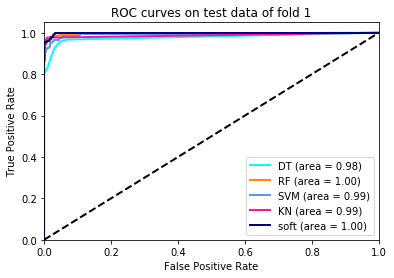

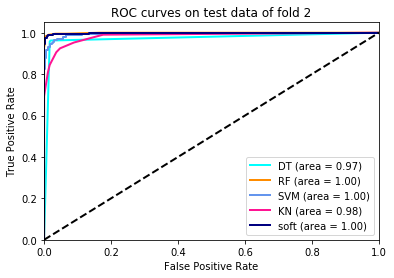

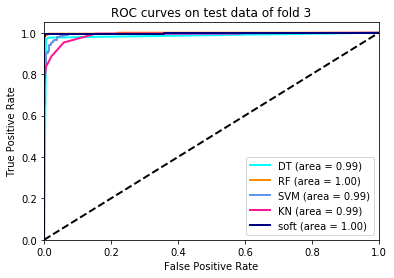

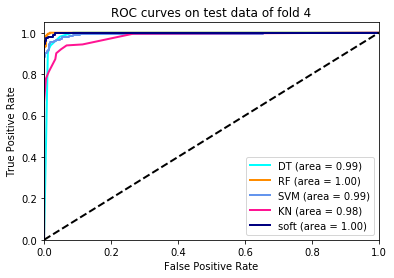

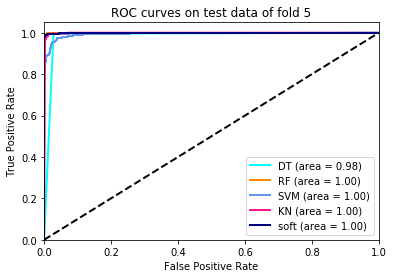

In [4]:
#ROC plots for test data per fold
lw = 2
clf_list = ['DT', 'RF', 'SVM', 'KN', 'soft']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue' , 'deeppink', 'navy'])

for fold in range(nfolds):
    for clf, color in zip(clf_list, colors):
        plt.plot(fpr_test_dict[clf+str(fold)], tpr_test_dict[clf+str(fold)], color=color, lw=lw,
                 label='{0} (area = {1:0.2f})'
                 ''.format(clf, roc_test_dict[clf+str(fold)]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves on test data of fold '+str(fold+1))
    plt.legend(loc="lower right")
    plt.savefig("Roc_test_fold"+str(fold)+".png")
    plt.show()

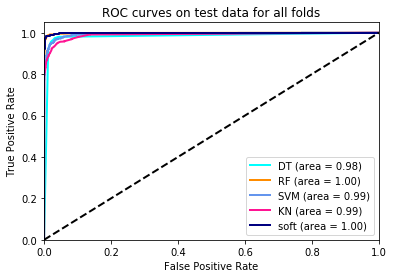

In [5]:
for label, color in zip(clf_list, colors):
    fpr_test, tpr_test, _ = roc_curve(test_y_dict[label+'All'], test_pred_dict[label+'All'])
    roc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(label, roc_test))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves on test data for all folds')
plt.legend(loc="lower right")
plt.savefig("Roc_test_all_folds.png")
plt.show()

# ROC plots (train data)

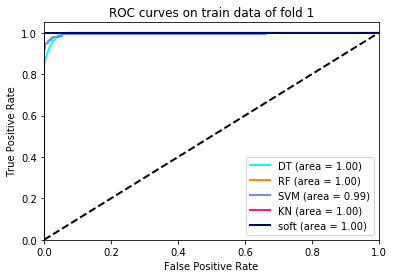

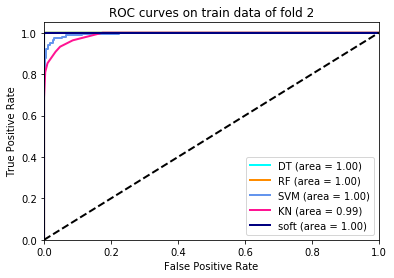

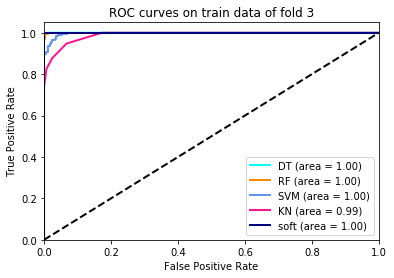

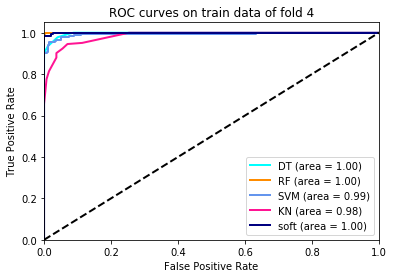

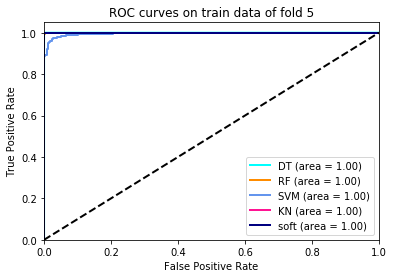

In [6]:
#ROC plots for test data per fold
lw = 2
clf_list = ['DT', 'RF', 'SVM', 'KN', 'soft']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue' , 'deeppink', 'navy'])

for fold in range(nfolds):
    for clf, color in zip(clf_list, colors):
        plt.plot(fpr_train_dict[clf+str(fold)], tpr_train_dict[clf+str(fold)], color=color, lw=lw,
                 label='{0} (area = {1:0.2f})'
                 ''.format(clf, roc_train_dict[clf+str(fold)]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves on train data of fold '+str(fold+1))
    plt.legend(loc="lower right")
    plt.savefig("Roc_train_fold"+str(fold)+".png")
    plt.show()

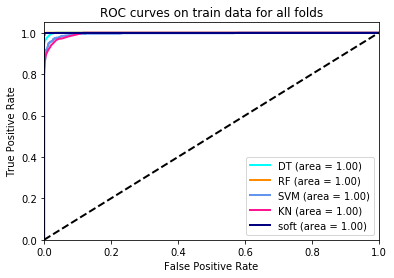

In [7]:
for label, color in zip(clf_list, colors):
    fpr_train, tpr_train, _ = roc_curve(train_y_dict[label+'All'], train_pred_dict[label+'All'])
    roc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(label, roc_train))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves on train data for all folds')
plt.legend(loc="lower right")
plt.savefig("Roc_train_all_folds.png")
plt.show()

# Accuracy table

In [8]:
#create a table containing the scores of the models trained with no split for the train data

#group df_scores per fold
folds_grouped2 = df_scores2.groupby('classifier').agg({'train acc':['mean','std'], 'test acc':['mean','std']})
folds_grouped2

train acc            test acc          
                mean       std      mean       std
classifier                                        
DT          0.985508  0.015877  0.970826  0.012464
KN          0.964396  0.032613  0.957469  0.021788
RF          0.996045  0.002866  0.987346  0.006263
SVM         0.972317  0.003354  0.967663  0.002358
soft        0.997363  0.003611  0.988401  0.005063